['LiF' 'LiCl' 'LiBr' 'LiI' 'NaF' 'NaCl' 'NaBr' 'NaI' 'KF' 'KCl' 'KBr' 'KI'
 'RbF' 'RbCl' 'RbBr' 'RbI']
[4.028 5.14 5.502 6.0 4.634 5.64 5.978 6.474 5.348 6.294 6.596 7.066 5.63
 6.582 6.89 7.342]
[5.083 3.256 2.767 3.176 3.702 2.746 2.345 2.063 2.873 2.295 2.059 1.874
 2.409 2.036 1.851 1.705]


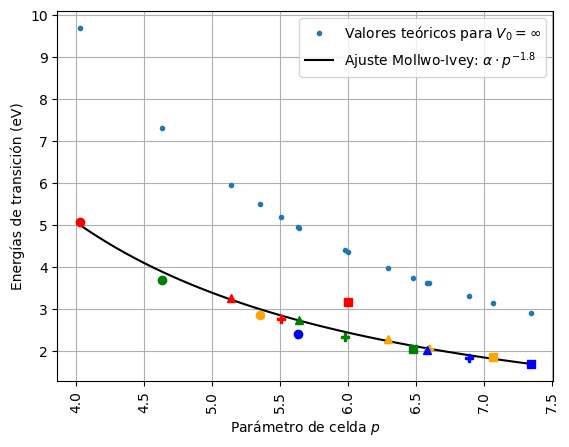

In [1]:
#Pozo infinito
from lib_experimental import Datos
import pandas as pd
from numpy import sin,cos,pi,tan,array,vectorize, arange,linspace,sqrt,argmin,std
from scipy.optimize import bisect,fsolve
import matplotlib.pyplot as plt

datos=pd.read_excel("Datos (Octavio).xlsx").values
z10=pi
z11=fsolve(lambda x: tan(x)-x,4.49)[0]
zcuad=z11**2-z10**2

m=9.1093837139e-31
h=6.62607015e-34
c=299792458
hbarra=h/(2*pi)
eVaJ=1.602176634e-19
ancho=0.5*datos[:,1]*10**(-10)

funcion_teorica=(lambda x: zcuad*hbarra**2/(2*m*x*x))
funcion_ajuste=lambda A,x: A[0]*x**-1.8

valores_teoricos=vectorize(funcion_teorica)(ancho)/eVaJ

marcador=array(["o","^","P","s"])
colores=["red","green","orange","blue"]
for i in range(4):
  for j in range(4):
    plt.errorbar(datos[4*i+j,1],datos[4*i+j,2],yerr=datos[4*i+j,2]*0.001,color=colores[i],marker=marcador[j])


#plt.(datos[:,1],datos[:,2],yerr=datos[:,2]*0.001,fmt="*",label="Datos experimentales")
plt.plot(datos[:,1],valores_teoricos,".",label=r"Valores teóricos para $V_0=\infty$")

k=Datos(list(datos[:,1]),list(datos[:,2]))
k.ajustar(funcion_ajuste,[1])

x=linspace(min(datos[:,1]),max(datos[:,1]))
print(datos[:,0])
print(datos[:,1])
print(datos[:,2])

plt.plot(x,funcion_ajuste(k.resultado_ajuste,x),label=r"Ajuste Mollwo-Ivey: $\alpha\cdot p^{-1.8}$",color="black")
plt.grid()
plt.legend()
plt.xticks(rotation=90, ha="center")
plt.xlabel(r"Parámetro de celda $p$")
plt.ylabel("Energías de transición (eV)")
plt.savefig("pot_infinito.png",dpi=600)

In [2]:
#Potencial finito
from numpy.random import normal
def raiz_0(V0,a):
  tol=1e-7
  R0cuad=2*m*V0*a*a/(hbarra*hbarra)
  R0=sqrt(R0cuad)
  f=lambda x: x/tan(x)+sqrt(R0cuad-x*x)
  r=bisect(f,tol,min(pi-tol,R0-tol))
  return r

def raiz_1(V0,a):
  tol=1e-10
  R0cuad=(2*m*V0)*a*a/(hbarra*hbarra)
  R0=sqrt(R0cuad)
  f=lambda x: (R0cuad-x*x)*x/tan(x)-x*x*sqrt(R0cuad-x*x)-R0cuad
  r=bisect(f,pi+tol,min(R0-tol,2*pi))
  return r

def DeltaE(V0,a):
  return (raiz_1(V0,a)**2-raiz_0(V0,a)**2)*hbarra*hbarra/(2*m*a*a)

def optimizarV0(a,Eexp,variar=False):
  tol=1e-6
  lista=[]

  def fmin(V0):
    R0=sqrt(2*m*V0*a*a/(hbarra*hbarra))
    DE=DeltaE(V0,a)
    return (DE-Eexp)**2
    v=0
  if variar:
    Eguardado=Eexp
    for i in range(1000):
      Eexp=Eguardado+normal(0,Eguardado*0.002)
      u=linspace(pi**2*hbarra**2/(2*m*a**2*eVaJ)+tol,(3*pi)**2*hbarra**2/(2*m*a**2*eVaJ),100)
      fdeu=vectorize(fmin)(u*eVaJ)
      lista.append(u[argmin(fdeu)])
    return std(lista)
  else:
    u=linspace(pi**2*hbarra**2/(2*m*a**2*eVaJ)+tol,(3*pi)**2*hbarra**2/(2*m*a**2*eVaJ),10000)
    fdeu=vectorize(fmin)(u*eVaJ)
    return u[argmin(fdeu)]

errores_potencial=vectorize(optimizarV0)(datos[:,1]*0.5e-10,datos[:,2]*eVaJ,variar=True)
valores_potencial=vectorize(optimizarV0)(datos[:,1]*0.5e-10,datos[:,2]*eVaJ)

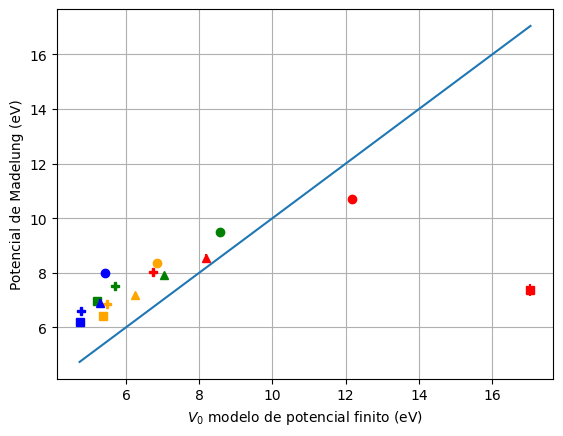

In [3]:
"""errores_potencial=[1.77635684e-15, 4.09837834e-02, 1.26905086e-02, 1.08637720e-01,
 0.00000000e+00, 1.77635684e-15, 3.70334973e-02, 2.04544875e-02,
 2.66453526e-15, 8.88178420e-16, 0.00000000e+00, 1.08760313e-02,
 1.77635684e-15, 1.36841843e-01, 8.88178420e-16, 2.74076898e-02]
valores_potencial=array([12.16320279,  8.17568429,  6.72976459, 17.04464546,  8.57353707,  7.03625708,
  5.7074487,   5.21382836,  6.84942965,  6.25146307 , 5.47636824,  5.37705075,
  5.42872014,  5.28857714 , 4.78069059 , 4.73257678])"""
from numpy import exp,sqrt
alfa=1.748
e=eVaJ
epsilon0=8.8541878128e-12
g=lambda R0,rho,a: alfa*e**2/(R0*4*pi*epsilon0*eVaJ)*(1-rho/R0)
pot_madelung=vectorize(g)(datos[:,3]*1e-10,datos[:,5]*1e-10,ancho)

E0=(vectorize(raiz_0)(valores_potencial*eVaJ,ancho)**2*hbarra*hbarra/(2*m*ancho*ancho))/eVaJ
E1=(vectorize(raiz_1)(valores_potencial*eVaJ,ancho)**2*hbarra*hbarra/(2*m*ancho*ancho))/eVaJ

marcador=array(["o","^","P","s"])
colores=["red","green","orange","blue"]
for i in range(4):
  for j in range(4):
    plt.errorbar(valores_potencial[4*i+j],pot_madelung[4*i+j],yerr=errores_potencial[4*i+j],color=colores[i],marker=marcador[j],zorder=4*i+j)

x=linspace(min(valores_potencial),max(valores_potencial))
plt.plot(x,x)
plt.grid()
plt.xlabel(r"$V_0$ modelo de potencial finito (eV)")
plt.ylabel("Potencial de Madelung (eV)")
plt.savefig("pot_finito.png",dpi=600)

3
